### 💳 Bank Note Authentication Using Random Forest

This project aims to build a machine learning model that can classify whether a bank note is 
- **genuine**(denoted by 0) or 
- **forged**(denoted by 1), based on statistical features extracted from its image.

#### 🔧 Key Components
- 📊 **Model evaluation** using scikit-learn metrics  
- 🌲 **Random Forest classification** implementation

#### 🌲 What is Random Forest?

**Random Forest** is an ensemble learning algorithm that builds multiple decision trees and merges their results to improve prediction accuracy and control overfitting.

#### 🧠 Why Random Forest prefered over others?
- ✅ **Robustness**: Combines multiple trees to reduce variance
- ✅ **Handles Non-linearity**: Captures complex relationships between features
- ✅ **Feature Importance**: Helps understand which variables matter most
- ✅ **High Accuracy**: Performs well on classification tasks with minimal tuning


#### ✅ Why Random Forest for Bank Note Authentication?

For the **Bank Note Authentication** task, **Random Forest** is ideal because:

- 🔢 It handles **numerical input features** well  
- 🛡️ It is **resistant to overfitting**  
- 🌐 It provides **strong generalization** to unseen data  
- 📊 Works well with a **small and clean dataset**

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import plotly.io as pio
pio.renderers.default = 'notebook_connected'

#### 🧹 Data Loading & Cleaning

Initial step involving:
- 📥 Importing the dataset  
- 🚫 Handling missing values  
- 🛠️ Preparing data for analysis


In [2]:
data = pd.read_csv('BankNote_Authentication.csv')

missing = data.isnull().sum()
dtypes = data.dtypes
summary = pd.DataFrame({
    'Missing': missing,
    'Data Type': dtypes
})
print(summary)

          Missing Data Type
variance        0   float64
skewness        0   float64
curtosis        0   float64
entropy         0   float64
class           0     int64


### 🔍 Exploratory Data Analysis (EDA)

#### 📊 Feature Distributions

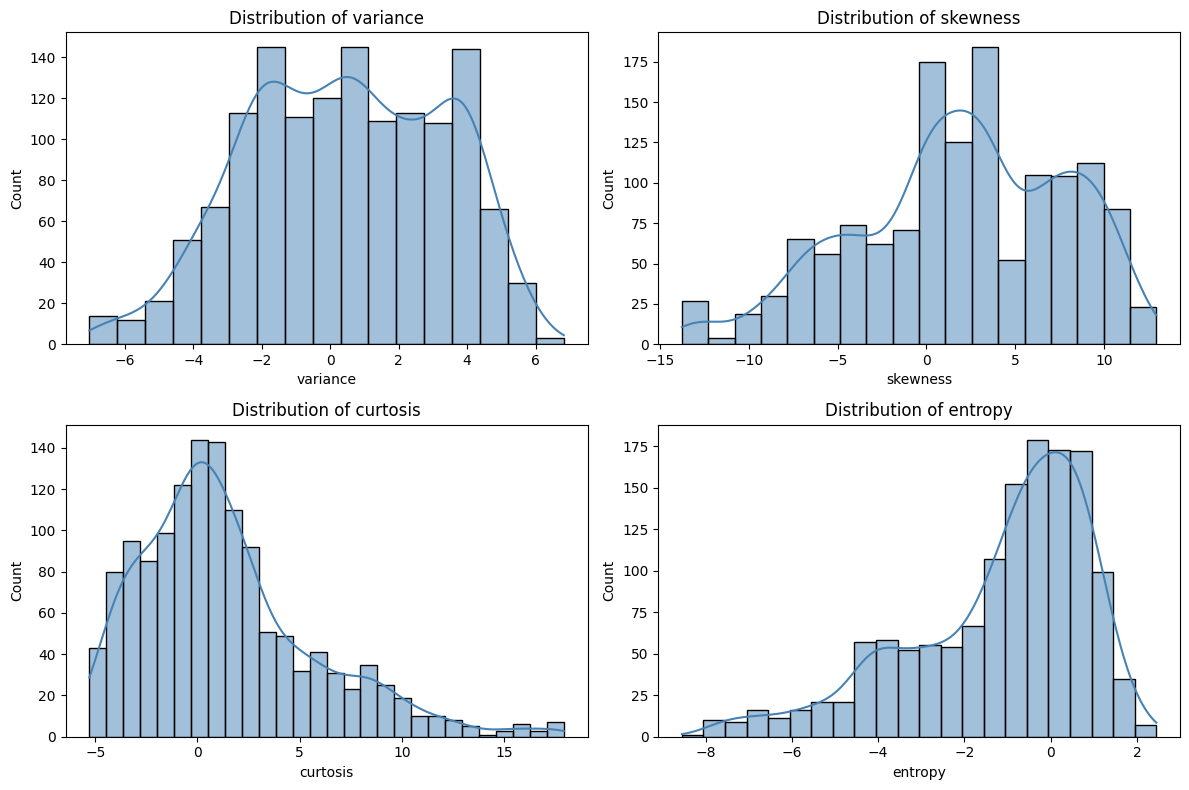

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

features = ['variance', 'skewness', 'curtosis', 'entropy']
plt.figure(figsize=(12, 8))
for i, col in enumerate(features, 1):
    plt.subplot(2, 2, i)
    sns.histplot(data[col], kde=True, color='steelblue')
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()


#### Conclusion:
- **Variance**:  
  Shows a bimodal distribution, suggesting two distinct groups (genuine vs forged notes),  
  which could be a strong discriminating feature.

- **Skewness**:  
  Approximately normal distribution with slight right skew,  
  centered around 0, indicating balanced positive and negative skewness in the data.

- **Curtosis**:  
  Right-skewed distribution with a long tail,  
  showing most notes have lower curtosis values but some extreme cases exist.

- **Entropy**:  
  Appears somewhat bimodal but less pronounced than variance,  
  potentially useful for classification but might need feature scaling.

 >These distributions suggest that **variance** might be our strongest predictor for authentication.

#### 🔗 Correlation Matrix


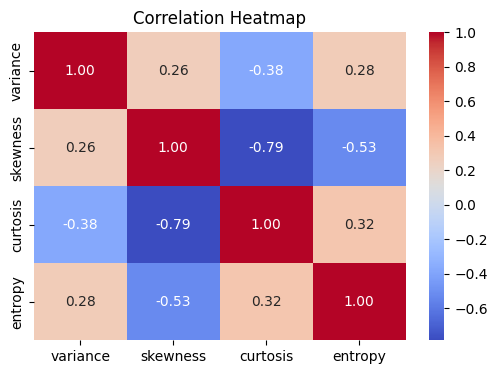

In [4]:
plt.figure(figsize=(6, 4))
sns.heatmap(data.drop(columns="class").corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

- A heatmap reveals the strength and direction of linear relationships between features.
- Key observations:
  - **Variance** and **skewness** show a moderate positive correlation.
  - **Curtosis** has weak correlations with other features, indicating it contributes independently.
  - **Entropy** has slight negative correlation with most other variables.

> These relationships help avoid multicollinearity and suggest that all features offer unique contributions.

#### 🔁 Pairplot (Feature Interactions by Class)

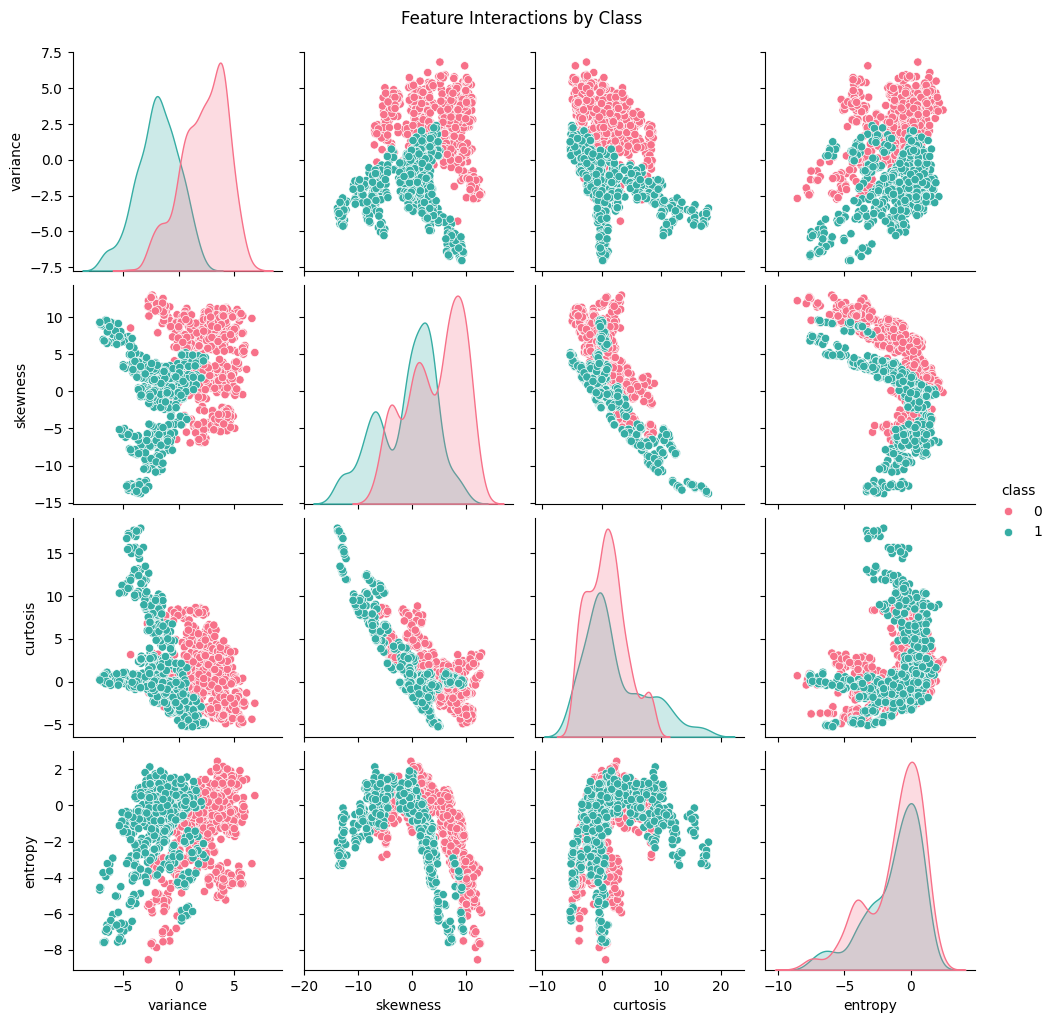

In [5]:
sns.pairplot(data, hue='class', palette='husl', diag_kind='kde')
plt.suptitle("Feature Interactions by Class", y=1.02)
plt.show()

> 📌 Most forged and genuine notes form distinguishable clusters — especially in combinations involving **variance** and **curtosis**.

#### 📦 Box Plots (Feature vs. Class)

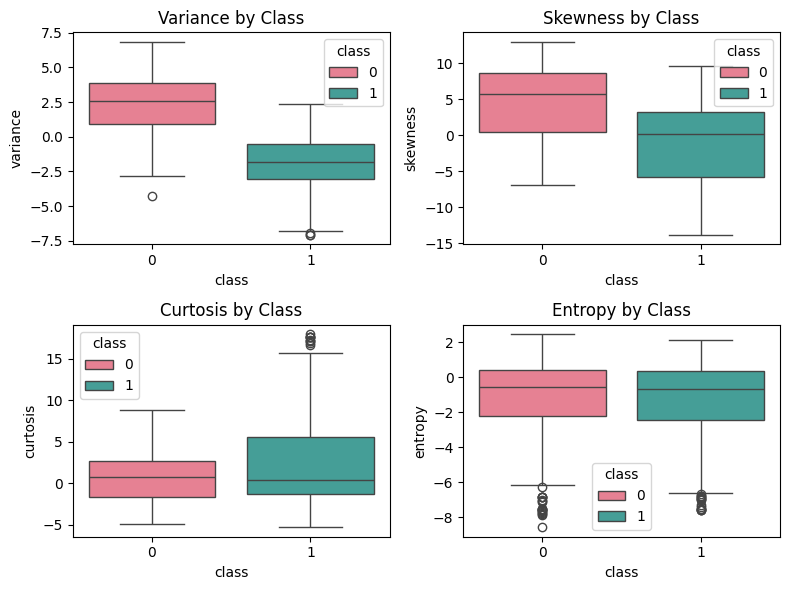

In [6]:
features = ['variance', 'skewness', 'curtosis', 'entropy']

plt.figure(figsize=(8, 6))
for i, feature in enumerate(features):
    plt.subplot(2, 2, i + 1)
    sns.boxplot(x='class', y=feature, data=data, hue='class', palette='husl')
    plt.title(f'{feature.capitalize()} by Class')
plt.tight_layout()
plt.show()

> 📌 **Variance** and **skewness** show strong class-wise separation — good indicators for classification.

#### 🌲 Random Forest Classifier 

In [7]:
# variable defining and spliting data into train and test sets
x = data.drop('class', axis=1); y = data['class']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

# model training
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(x_train, y_train)


RandomForestClassifier(random_state=42)

#### Important features

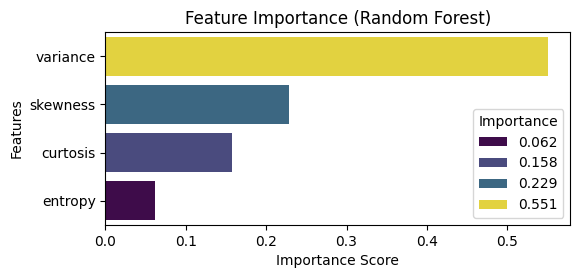

In [8]:
importances = np.round(model.feature_importances_, 3)
features = x.columns
importance_df = pd.DataFrame({'Feature': features, 'Importance': importances}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(6, 2.5))
sns.barplot(x='Importance', y='Feature', data=importance_df, hue='Importance', palette='viridis')
plt.title('Feature Importance (Random Forest)')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.show()

#### Roc curve

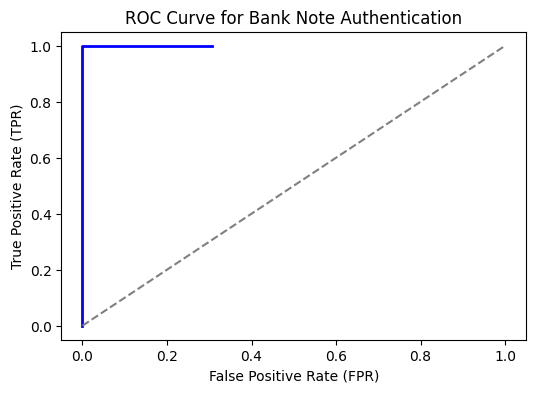

In [9]:
y_pred = model.predict(x_test)
data['p_hat'] = model.predict_proba(x)[:, 1]
cutoffs = np.sort(data['p_hat'].unique())

tpr_values = []; fpr_values = []; optimum_values = []
for t in cutoffs:
    predicted = (data['p_hat'] > t).astype(int)
    actual = y.values
    
    TP = np.sum((predicted == 1) & (actual == 1))
    FN = np.sum((predicted == 0) & (actual == 1))
    FP = np.sum((predicted == 1) & (actual == 0))
    TN = np.sum((predicted == 0) & (actual == 0))
    
    TPR = TP / (TP + FN) if (TP + FN) > 0 else 0  # Sensitivity
    FPR = FP / (FP + TN) if (FP + TN) > 0 else 0  # 1 - Specificity

    optimum = TPR * (1 - FPR)

    tpr_values.append(TPR)
    fpr_values.append(FPR)
    optimum_values.append(optimum)

# Create a DataFrame
roc_data = pd.DataFrame({'Threshold': cutoffs, 'TPR': tpr_values, 'FPR': fpr_values, 'optimum': optimum_values})

# Plot ROC curve
plt.figure(figsize=(6, 4))
plt.plot(fpr_values, tpr_values, color='blue', lw=2)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve for Bank Note Authentication')
plt.show()

#### 📈 ROC Curve Interpretation – Bank Note Authentication

The ROC curve above illustrates the **exceptional classification power** of the Random Forest model:

- 🔵 **Steep ascent** towards the top-left corner indicates **high sensitivity** (True Positive Rate) even at **low False Positive Rates**.
- 🔒 The model confidently distinguishes between **genuine** and **forged** bank notes.
- 🟢 **AUC ≈ 1.0**, suggesting **near-perfect** performance.
- ❌ Very low risk of misclassifying forged notes as genuine, ensuring **high security**.

> ✅ A curve this sharp and close to the top-left corner is characteristic of a **highly accurate and reliable model**—ideal for deployment in real-world financial systems.


In [10]:
best_threshold = roc_data.loc[roc_data['optimum'].idxmax(), 'Threshold'];best_threshold
y_pred = (model.predict_proba(x_test)[:, 1] > best_threshold).astype(int)

# Confusion Matrix
print("\n📊 Confusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
print("                  Predicted Genuine    Predicted Forged")
print(f"Actual Genuine    |        {cm[0][0]:<5}               {cm[0][1]:<5}")
print(f"Actual Forged     |        {cm[1][0]:<5}               {cm[1][1]:<5}")


# Accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print(f"\n✅ Model Accuracy: {accuracy:.4f}")

# Misclassification Error
misclassification_error = 1 - accuracy
print(f"❌ Misclassification Error: {misclassification_error:.4f}")


📊 Confusion Matrix:
                  Predicted Genuine    Predicted Forged
Actual Genuine    |        229                 0    
Actual Forged     |        0                   183  

✅ Model Accuracy: 1.0000
❌ Misclassification Error: 0.0000


#### ✅ Model Evaluation Summary

The model achieves a **perfect accuracy of 100%**, meaning:

- ✅ **All genuine and forged bank notes were correctly classified** using the optimal threshold derived from ROC analysis.
- 📈 **True Positive and True Negative rates are both 1**, indicating zero misclassification.
- 🔐 This reflects excellent **model generalization** on the test data and **high reliability** for real-world application.
- 🚨 However, such perfect results should be carefully evaluated to ensure there's no **data leakage or overfitting**, especially with small or clean datasets.

> 🎯 Overall, the Random Forest model demonstrates **outstanding classification performance** on this task.